## DSCI 552 PS 1 - Used Car Dataset
#### Erica Xia

In [1]:
import warnings
warnings.filterwarnings('ignore')

## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
## import custom function to get feature names
from helper import get_feature_names

In [3]:
df = pd.read_csv(r'../data/used_car_dataset.csv')
print(df.shape)

(9997, 14)


In [4]:
df.head(3)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b


In [5]:
# df.describe()

In [6]:
# df.info()

# EDA, Data Cleaning, and Transforming steps
Due to skewed datasets, we should clean data by: fill missing vals (median imputation), scale the datasets (minmaxscaler), remove outliers, and do one-hot encoding for categorical vars.

In [7]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols_no_price = ['year', 'odometer', 'F1', 'F2', 'F3']

In [8]:
## Normalize data
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)
outliers = list(set(outlier_locs))
## df2 is just df without the outliers
df2 = df.drop(df.index[outliers])
nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(9997, 14) (9603, 14)


<AxesSubplot:>

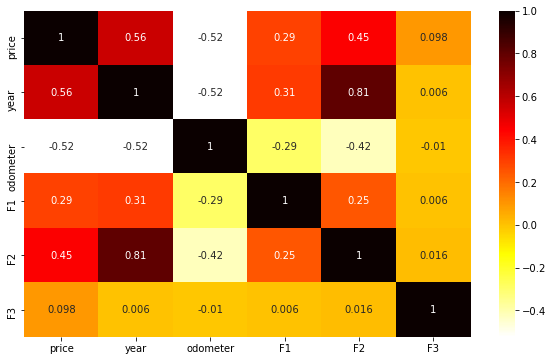

In [9]:
# ## View correlations btwn features
plt.figure(figsize=(10,6))
sns.heatmap(df2.corr(), annot=True, cmap="hot_r")
# # plt.savefig('images/heatmap_1.png')

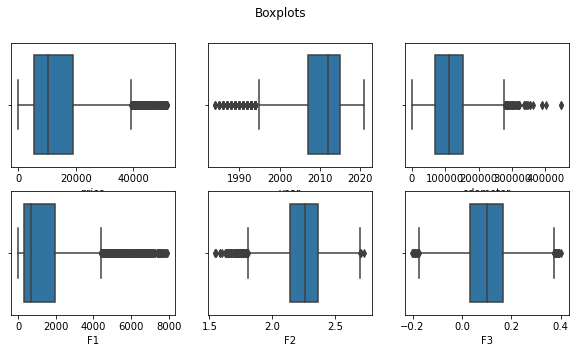

In [10]:
# ## boxplots for numerical vars
fig, axes = plt.subplots(2, 3, sharex = False, figsize=(10,5))
fig.suptitle('Boxplots')

for i, var in enumerate(num_cols):
    if i < 3:
        row = 0
    elif i >= 3: 
        row = 1
    col = i % 3
    sns.boxplot(ax=axes[row,col], data=df2, x=var)
# plt.savefig('images/boxplots_1.png')

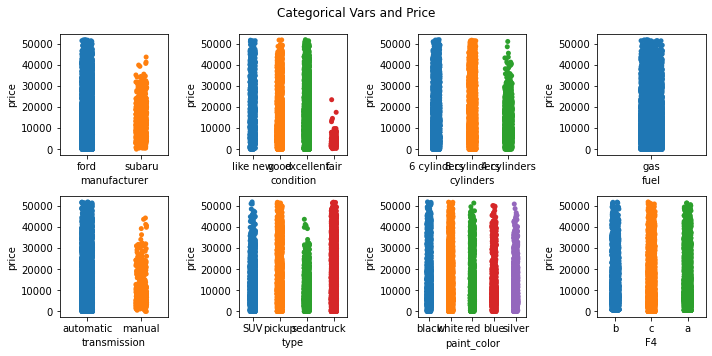

In [11]:
# ## Categorical vars and Price
fig, axes = plt.subplots(2, 4, sharex = False, figsize=(10,5))
fig.suptitle('Categorical Vars and Price')
for i, var in enumerate(cat_cols):
    if i < 4:
        row = 0
    elif i >= 4: 
        row = 1
    col = i % 4
    axes[row][col] = sns.stripplot(x=var, y='price', data=df2, ax=axes[row][col])
fig.tight_layout()
# plt.savefig('images/catplots_and_price_1.png')


Text(0.5, 1.0, 'Distribution of Price')

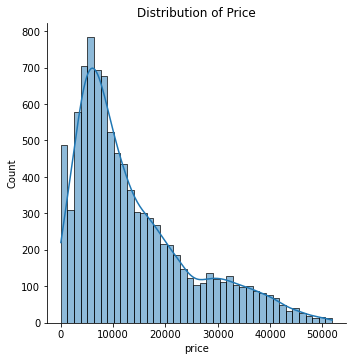

In [12]:
g = sns.displot(data=df2, x='price', kde=True)
g.fig.subplots_adjust(top=.95)
g.ax.set_title("Distribution of Price")
# # plt.savefig('../images/PS_1/price_histogram.png')

Text(0.5, 1.0, 'Price by Type')

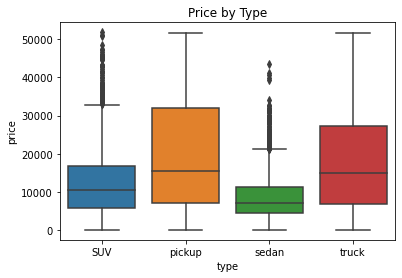

In [13]:
# ## How does price vary across types?
sns.boxplot(x='type', y='price', data=df2)
plt.title("Price by Type")
# # plt.savefig('../images/PS_1/price_type_boxplot.png')|

Greater variability for pickup and truck types and they have similar medians. SUV and sedan have lower variability and more concentration of higher-priced outliers.

Text(0.5, 1.0, 'Price by Cylinders')

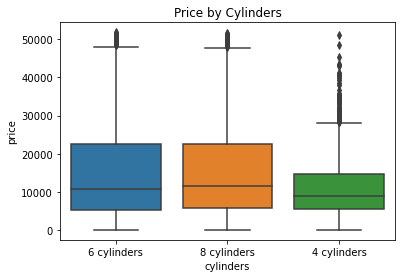

In [14]:
# ## How does price vary across num. of cylinders?
sns.boxplot(x='cylinders', y='price', data=df2)
plt.title("Price by Cylinders")
# # plt.savefig('../images/PS_1/price_cylinders_boxplot.png')

Greater variability for 6 and 8 cylinder cars. 

<AxesSubplot:title={'center':'Price By Year'}, xlabel='year', ylabel='price'>

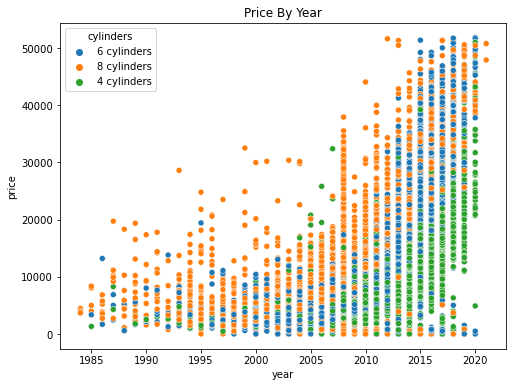

In [15]:
plt.figure(figsize=(8,6))
plt.title("Price By Year")
sns.scatterplot(x='year', y='price', hue='cylinders', data=df2)
# # plt.savefig('../images/PS_1/price_by_year_cylinders.png')

<AxesSubplot:title={'center':'Price By Year'}, xlabel='year', ylabel='price'>

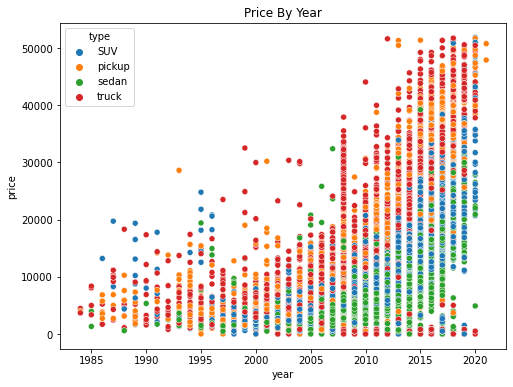

In [16]:
plt.figure(figsize=(8,6))
plt.title("Price By Year")
sns.scatterplot(x='year', y='price', hue='type', data=df2)
# # plt.savefig('../images/PS_1/price_by_year_type.png')

# OLS regression 
## Transformation Pipeline

In [17]:
df3 = df2.drop(['price'],axis=1)
df3.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


In [18]:
## TRANSFORM STEP (After outlier removal)
## Transforms the dataset to prep for model
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

## drop first dummy vars for Lin Reg
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols_no_price),
    ("categorical", OneHotEncoder(drop='first'), cat_cols)
])

arr = full_pipeline.fit_transform(df3)  ### dropped dummy vars
print(arr.shape) # After outlier removal
feature_names = get_feature_names(full_pipeline)

(9603, 21)


In [19]:
vifs = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
print(len(vifs))
## NOTE: any VIF > 4 needs investigation for possible multicollinearity!
print(sorted(vifs)[::-1])

21
[299.26406445266826, 249.98519659110258, 6.100689119014561, 4.261642179609693, 3.233789149309924, 2.7768443447454043, 2.434597928073263, 2.0947094867570377, 2.075663063670362, 2.042564447221222, 2.0146611451577114, 1.9759717879300158, 1.947545652635113, 1.839372519729242, 1.829295445789961, 1.8128542011234523, 1.6952636550763105, 1.4731098862391672, 1.2713370940472877, 1.1792243125126092, 1.1647149809472024]


In [20]:
## Split in train/test/valid
X = arr
y = df2['price'].to_numpy()  ## target var is UNSCALED
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 21) (9603,)
(7682, 21) (1921, 21)


In [21]:
n = X.shape[0]  ## sample size
p = X.shape[1]  ## num of predictors

In [22]:
## OLS Linear Reg Model - using sm
## with UNSCALED data and dropped dummy vars
X_train_df = pd.DataFrame(X_train, columns=feature_names)
# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     565.9
Date:                Mon, 08 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:21:52   Log-Likelihood:                -78796.
No. Observations:                7682   AIC:                         1.576e+05
Df Residuals:                    7660   BIC:                         1.578e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.823e+06   4.91e+04    -37.164      0.000   -1.92e+06   -1.73e+06
numerical__year               913.7979     24.998     36.555      0.000     864.795     962.801
numerical__odometer            -0.0521      0.002    -32.604      0.000      -0.055      -0.049
numerical__F1                   0.3169      0.054      5.827      0.000       0.210       0.424
numerical__F2                -252.7499    786.228     -0.321      0.748   -1793.973    1288.473
numerical__F3                1.011e+04    792.827     12.756      0.000    8559.152    1.17e+04
categorical__x0_subaru       3061.0933    302.556     10.117      0.000    2468.000    3654.186
categorical__x1_fair        -1418.3343    464.605     -3.053      0.002   -2329.087    -507.582
categorical__x1_good         -297.1410    178.387     -1.666      0.096    -646.828      52.546
categorical__x1_like new     1286.7560    266.482      4.829      0.000     764.379    1809.133
categorical__x2_6 cylinders  4205.5344    235.085     17.889      0.000    3744.704    4666.365
categorical__x2_8 cylinders  5567.0898    291.819     19.077      0.000    4995.044    6139.136
categorical__x4_manual       3160.7834    406.188      7.782      0.000    2364.544    3957.023
categorical__x5_pickup       6075.2469    265.113     22.916      0.000    5555.552    6594.942
categorical__x5_sedan       -2833.1737    220.862    -12.828      0.000   -3266.124   -2400.224
categorical__x5_truck        5280.2196    245.088     21.544      0.000    4799.781    5760.658
categorical__x6_blue         -675.1528    282.494     -2.390      0.017   -1228.918    -121.387
categorical__x6_red          -149.3982    264.903     -0.564      0.573    -668.680     369.884
categorical__x6_silver       -873.7386    265.608     -3.290      0.001   -1394.403    -353.074
categorical__x6_white       -1491.5732    225.726     -6.608      0.000   -1934.057   -1049.089
categorical__x7_b              65.3542    191.254      0.342      0.733    -309.556     440.265
categorical__x7_c            -280.9212    194.890     -1.441      0.150    -662.959     101.117
==============================================================================
Omnibus:                     1015.318   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4702.931
Skew:                          -0.567   Prob(JB):                         0.00
Kurtosis:                       6.661   Cond. No.                     7.89e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+07. This might indicate that there are
strong multicollinearity or o

In [23]:
params = model.params
params.sort_values(ascending=False)

numerical__F3                  1.011331e+04
categorical__x5_pickup         6.075247e+03
categorical__x2_8 cylinders    5.567090e+03
categorical__x5_truck          5.280220e+03
categorical__x2_6 cylinders    4.205534e+03
categorical__x4_manual         3.160783e+03
categorical__x0_subaru         3.061093e+03
categorical__x1_like new       1.286756e+03
numerical__year                9.137979e+02
categorical__x7_b              6.535424e+01
numerical__F1                  3.169477e-01
numerical__odometer           -5.209295e-02
categorical__x6_red           -1.493982e+02
numerical__F2                 -2.527499e+02
categorical__x7_c             -2.809212e+02
categorical__x1_good          -2.971410e+02
categorical__x6_blue          -6.751528e+02
categorical__x6_silver        -8.737386e+02
categorical__x1_fair          -1.418334e+03
categorical__x6_white         -1.491573e+03
categorical__x5_sedan         -2.833174e+03
const                         -1.822998e+06
dtype: float64

In [24]:
## Predict on test values
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X0_test = sm.add_constant(X_test_df)
y_pred = model.predict(X0_test)

In [25]:
## get RMSE
rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
round(rmse,4)

7243.0742

In [26]:
# 10 fold cv for OLS using sklearn
def list_models(models = dict()):
    models['linear_reg'] = LinearRegression()
    alphas = [round(x, 2) for x in np.linspace(0,1,11)]
    for a in alphas:
        models['lasso_reg_'+str(a)] = Lasso(alpha=a)
        models['ridge_reg_'+str(a)] = Ridge(alpha=a)
        models['en_reg_'+str(a)] = ElasticNet(alpha=a)
    return models
 
def eval_one_model(X, y, model, folds, metric):
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

def eval_multi_models(X, y, models, folds=10, metric='neg_root_mean_squared_error'):   
    results = {}
    print(f"Evaluate using {metric}:\n")
    for name, model in models.items():
        scores = eval_one_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{name}: Mean {metric}:{mean_score:.3f}')
    return results

results = eval_multi_models(X, y, {'linear_reg': LinearRegression()})

Evaluate using neg_root_mean_squared_error:

linear_reg: Mean neg_root_mean_squared_error:-6975.212


In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
r2 = round(r2_score(y_test, y_pred) ,4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Coefficient of determination R^2: 0.5695
Adjusted R^2 is 0.5686


# Regularized Regression for Modeling and Comparing Models

In [28]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmaxscaler', MinMaxScaler())
])

## pipeline for Regularized Regression
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols_no_price),
    ("categorical", OneHotEncoder(), cat_cols)
])

arr_cleaned = full_pipeline.fit_transform(df3)
print(arr_cleaned.shape) # After outlier removal
feature_names = get_feature_names(full_pipeline)

(9603, 29)


In [29]:
## Split in train/test/valid
X = arr_cleaned
y = df2['price'].to_numpy()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 29) (9603,)
(7682, 29) (1921, 29)


## Spot check / Compare models
#### Try diff models compare results using kfold cv

In [34]:
models = list_models() 
results = eval_multi_models(X, y, models)

Evaluate using neg_root_mean_squared_error:

linear_reg: Mean neg_root_mean_squared_error:-7016.673
lasso_reg_0.0: Mean neg_root_mean_squared_error:-6975.212
ridge_reg_0.0: Mean neg_root_mean_squared_error:-7052.890
en_reg_0.0: Mean neg_root_mean_squared_error:-6975.212
lasso_reg_0.1: Mean neg_root_mean_squared_error:-6975.211
ridge_reg_0.1: Mean neg_root_mean_squared_error:-6975.211
en_reg_0.1: Mean neg_root_mean_squared_error:-8037.064
lasso_reg_0.2: Mean neg_root_mean_squared_error:-6975.206
ridge_reg_0.2: Mean neg_root_mean_squared_error:-6975.212
en_reg_0.2: Mean neg_root_mean_squared_error:-8662.074
lasso_reg_0.3: Mean neg_root_mean_squared_error:-6975.196
ridge_reg_0.3: Mean neg_root_mean_squared_error:-6975.217
en_reg_0.3: Mean neg_root_mean_squared_error:-9051.750
lasso_reg_0.4: Mean neg_root_mean_squared_error:-6975.183
ridge_reg_0.4: Mean neg_root_mean_squared_error:-6975.224
en_reg_0.4: Mean neg_root_mean_squared_error:-9320.273
lasso_reg_0.5: Mean neg_root_mean_squared_err

In [35]:
mean_results = {name: np.abs(np.round(np.mean(arr), 4)) for name, arr in results.items()}
## sort results with 'best' models first (having lowest error scores)
sorted(mean_results.items(), key=lambda x: x[1])

[('lasso_reg_1.0', 6975.0589),
 ('lasso_reg_0.9', 6975.0784),
 ('lasso_reg_0.8', 6975.0982),
 ('lasso_reg_0.7', 6975.1191),
 ('lasso_reg_0.6', 6975.1382),
 ('lasso_reg_0.5', 6975.1562),
 ('lasso_reg_0.4', 6975.1833),
 ('lasso_reg_0.3', 6975.1964),
 ('lasso_reg_0.2', 6975.2056),
 ('lasso_reg_0.1', 6975.2106),
 ('ridge_reg_0.1', 6975.211),
 ('ridge_reg_0.2', 6975.2124),
 ('lasso_reg_0.0', 6975.2125),
 ('en_reg_0.0', 6975.2125),
 ('ridge_reg_0.3', 6975.2168),
 ('ridge_reg_0.4', 6975.224),
 ('ridge_reg_0.5', 6975.234),
 ('ridge_reg_0.6', 6975.2468),
 ('ridge_reg_0.7', 6975.2624),
 ('ridge_reg_0.8', 6975.2807),
 ('ridge_reg_0.9', 6975.3017),
 ('ridge_reg_1.0', 6975.3253),
 ('linear_reg', 7016.6731),
 ('ridge_reg_0.0', 7052.8904),
 ('en_reg_0.1', 8037.064),
 ('en_reg_0.2', 8662.0743),
 ('en_reg_0.3', 9051.7502),
 ('en_reg_0.4', 9320.2725),
 ('en_reg_0.5', 9518.0295),
 ('en_reg_0.6', 9670.6159),
 ('en_reg_0.7', 9792.481),
 ('en_reg_0.8', 9892.3975),
 ('en_reg_0.9', 9976.0398),
 ('en_reg_1.0',

Looks like Lasso does the best at alpha=1.0

In [36]:
mean_rmse_df = pd.DataFrame.from_dict(mean_results, orient='index')
mean_rmse_df.columns = ['RMSE']
mean_rmse_df = mean_rmse_df.sort_values(by='RMSE')
# mean_rmse_df.head(10)

<AxesSubplot:title={'center':'Model Results of 10-fold CV'}, xlabel='RMSE'>

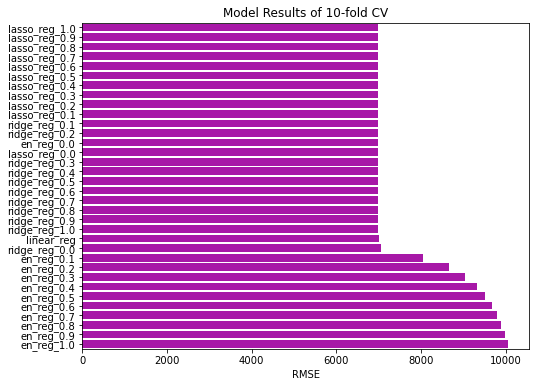

In [37]:
plt.figure(figsize=(8,6))
plt.title('Model Results of 10-fold CV')
sns.barplot(x='RMSE', y=mean_rmse_df.index, data=mean_rmse_df, color = 'm')
# plt.savefig('../images/PS_1/rmse_results_barchart.png')

# Plot Final Model

In [38]:
# Lasso model
alpha = 1.0
lasso_reg = Lasso(alpha=alpha)
print(lasso_reg)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
print('Coefficients: \n', lasso_reg.coef_)
print(f'Root Mean squared error: {round(mean_squared_error(y_test, y_pred_lasso, squared=False), 4)}')
r2 = round(r2_score(y_test, y_pred_lasso) ,4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Lasso()
Coefficients: 
 [ 3.36106479e+04 -2.32755136e+04  2.50170472e+03 -5.91178717e+01
  6.06742944e+03 -3.04748344e+03  0.00000000e+00  1.52005574e-01
 -1.39686171e+03 -2.93972146e+02  1.28119062e+03 -4.74619732e+03
 -5.43149969e+02  8.11238854e+02  0.00000000e+00 -3.13266713e+03
  1.13896837e-11 -2.61411761e+03  3.45572691e+03 -5.44544643e+03
  2.65910917e+03  6.68781225e+02  0.00000000e+00  5.19210756e+02
 -1.94302819e+02 -8.13166062e+02  0.00000000e+00  6.26865119e+01
 -2.77371226e+02]
Root Mean squared error: 7242.7204
Coefficient of determination R^2: 0.5695
Adjusted R^2 is 0.5686


In [39]:
lasso_results = list(zip(feature_names, lasso_reg.coef_))
lasso_res_df = pd.DataFrame(lasso_results, columns=['feature_name','coefficient'])
lasso_res_df['coefficient'] =lasso_res_df['coefficient'].round(2)
lasso_res_df = lasso_res_df.sort_values(by='coefficient', ignore_index=True)
print(lasso_res_df.shape)

(29, 2)


In [40]:
lasso_to_plot = pd.concat([lasso_res_df.head(10), lasso_res_df.tail(10)])

Text(0, 0.5, 'Magnitude')

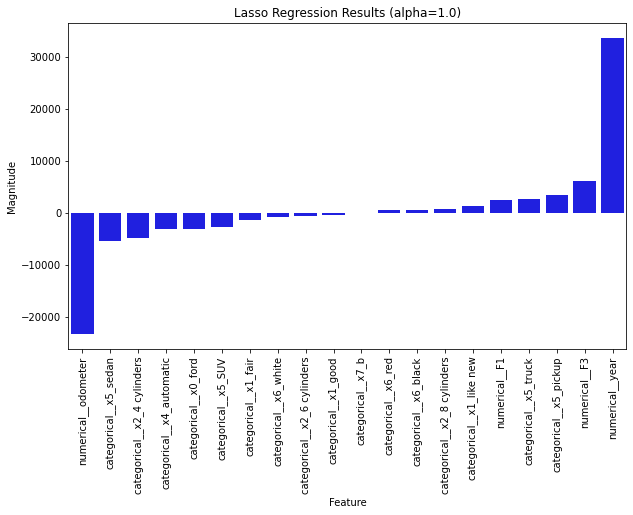

In [41]:
plt.figure(figsize=(10,6))
plt.title(f'Lasso Regression Results (alpha={alpha})')
sns.barplot(x='feature_name', y='coefficient', data=lasso_to_plot, color = 'b')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Magnitude')
# plt.savefig('../images/PS_1/lasso_coefficients.png')